# Image Classification with MobileNetV2

This notebook demonstrates an image classification task using a pre-trained MobileNetV2 model. The goal is to classify images of Indian bovines into 'Buffalo' and 'Cattle'.


## Setup and Imports

This cell imports necessary libraries for data handling, model building, training, evaluation, and visualization. It also sets up the device to use GPU if available.

In [1]:

import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
# 🧠 Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Mount Google Drive

This cell mounts Google Drive to access the dataset stored there.

In [2]:
# import zipfile
# import os
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)


## Extract Dataset

This cell extracts the zipped dataset from Google Drive into the notebook environment.

In [3]:
# import zipfile
# import os
# with zipfile.ZipFile("/content/drive/MyDrive/All/career/AIML_IIT/Assignment/FinalProject/BP Project/bovineCompleteData.zip", 'r') as zip_ref:
# #with zipfile.ZipFile("/content/drive/MyDrive/All/career/AIML_IIT/Assignment/Indian_bovine_balanced.zip", 'r') as zip_ref:
#     zip_ref.extractall("dataset")

import zipfile
 #import os
# with zipfile.ZipFile("/content/drive/MyDrive/All/career/AIML_IIT/Assignment/FinalProject/BP Project/bovineCompleteData.zip", 'r') as zip_ref:
# #with zipfile.ZipFile("/content/drive/MyDrive/All/career/AIML_IIT/Assignment/Indian_bovine_balanced.zip", 'r') as zip_ref:
    # zip_ref.extractall("dataset")
zip_path = "/kaggle/input/bovine-extended-Data.zip"
extract_to = "/kaggle/working/dataset"


## Data Transformations

This cell defines the image transformations to be applied to the dataset. These transformations include resizing, random horizontal flipping, random rotation, color jitter, converting to a tensor, and normalization.

In [4]:

# Path to full dataset (unsplit)
dataset_dir = '/kaggle/input/bovine-extended-data/bovine'
#dataset_dir = './dataset/bovine'
from torchvision import transforms

# Custom transform to convert image to RGB

class EnsureRGB:
    def __call__(self, img):
        if img.mode == 'P' or img.mode == 'LA':  # palette or grayscale+alpha
            return img.convert('RGBA').convert('RGB')
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

# Transform
transform = transforms.Compose([
    EnsureRGB(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
     transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        # Original tuple: (image_tensor, label)
        image, label = super().__getitem__(index)
        # Add image path
        path, _ = self.imgs[index]
        return image, label, path


## Data Loading and Splitting

This cell loads the dataset using `ImageFolder`, splits it into training, validation, and test sets using a stratified split to maintain class distribution, and creates data loaders for each set. It also creates a mapping from class indices to class names.

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import ImageFolder
import os

# 👇 Step 1: Load full dataset
#full_dataset = ImageFolder(dataset_dir, transform=transform)
full_dataset = ImageFolderWithPaths(dataset_dir, transform=transform)
class_names = full_dataset.classes
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# 👇 Step 2: Prepare indices and targets
total_size = len(full_dataset)
targets = [label for _, label in full_dataset.imgs]
indices = list(range(total_size))

# 👇 Step 3: Stratified split using sklearn
train_idx, temp_idx, train_y, temp_y = train_test_split(
    indices, targets, stratify=targets, test_size=0.3, random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx, stratify=temp_y, test_size=0.5, random_state=42
)

# ✅ Step 4: Create Subset datasets
train_data = Subset(full_dataset, train_idx)
val_data = Subset(full_dataset, val_idx)
test_data = Subset(full_dataset, test_idx)

# ✅ Step 5: DataLoaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

# ✅ Log info
print("Classes:", idx_to_class)
print("Train size:", len(train_data))
print("Validation size:", len(val_data))
print("Test size:", len(test_data))




Classes: {0: 'Buffalo', 1: 'Cattle'}
Train size: 3489
Validation size: 748
Test size: 748


## Initialize Metric Lists

This cell initializes empty lists to store training and validation losses, accuracies, and learning rates over epochs.

In [6]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss

## Model Definition, Loss Function, Optimizer, and Scheduler

This cell defines the model using a pre-trained MobileNetV2, freezes its feature extraction layers, and modifies the classifier head for the specific number of classes. It also computes class weights to handle potential class imbalance, defines the loss function (CrossEntropyLoss with class weights), the optimizer (Adam), and a learning rate scheduler (ReduceLROnPlateau) to adjust the learning rate during training. Early stopping parameters are also defined here.

In [8]:
from torchvision.models import MobileNet_V2_Weights
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 🔄 Load pre-trained MobileNetV2 with ImageNet weights
weights = MobileNet_V2_Weights.DEFAULT
model = models.mobilenet_v2(weights=weights)

# ❄️ Freeze all feature layers first
for param in model.features.parameters():
    param.requires_grad = False

# 🔓 Unfreeze deeper layers (for fine-tuning)
for idx in [15, 16, 17, 18]:
    for param in model.features[idx].parameters():
        param.requires_grad = True

# 🎯 Modify classifier for our number of classes
num_classes = len(full_dataset.classes)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

# ⚖️ Compute class weights for imbalance handling
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(targets),
                                     y=targets)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# 🎯 Define loss and optimizer (train classifier + last conv layers)
trainable_params = list(model.classifier.parameters()) + [
    param for idx in [15, 16, 17, 18] for param in model.features[idx].parameters()
]
#criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
criterion = FocalLoss(alpha=1, gamma=2)

optimizer = optim.Adam(trainable_params, lr=0.0005, weight_decay=1e-4)

# 🔽 Reduce LR on plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


# 📦 Early stopping config
num_epochs = 15
patience = 4
best_val_loss = float('inf')
patience_counter = 0
best_model_path = "best_model.pth"

# 📈 Tracking lists
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
lrs = []

# 🚂 Training function
def train_model(epochs=num_epochs):
    global patience_counter, best_val_loss
    early_stopped = False

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels, _ in train_loader:  # ✅ safely ignore paths
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # 🔍 Training metrics
        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # 🧪 Validation
        val_loss, val_acc = validate_model()
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # 🔁 Scheduler and Early Stopping
        scheduler.step(val_loss)
        lrs.append(optimizer.param_groups[0]['lr'])
        print("Current LR:", scheduler.optimizer.param_groups[0]['lr'])
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print("✅ Validation loss improved. Best model saved.")
        else:
            patience_counter += 1
            print(f"⏳ No improvement in val loss. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            early_stopped = True
            break

    return early_stopped


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 118MB/s] 


## Validation Function

This cell defines the `validate_model` function, which evaluates the trained model on the validation dataset. It calculates and returns the average validation loss and accuracy.

In [9]:
# 🔍 Validation loop
def validate_model():
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels, _ in val_loader:  # ✅ support for (image, label, path)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total
    return avg_val_loss, val_acc


## Plotting Function

This cell defines a function to plot the training and validation loss and accuracy curves, and optionally the learning rate curve. It also highlights the epoch with the best validation accuracy.

In [10]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, lrs=None):
    """
    Plot training and validation loss & accuracy with optional learning rate overlay.
    Highlights best validation accuracy.
    """
    best_epoch = val_accuracies.index(max(val_accuracies))
    best_acc = max(val_accuracies)

    plt.figure(figsize=(14, 5))

    # 🔹 Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='o')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(len(train_losses)))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # 🔹 Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(val_accuracies, label='Val Accuracy', marker='o')
    plt.axvline(best_epoch, color='green', linestyle='--', label=f'Best Epoch: {best_epoch+1}')
    plt.scatter(best_epoch, best_acc, color='red')
    plt.text(best_epoch, best_acc + 1, f'{best_acc:.2f}%', ha='center', fontsize=9)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(len(train_losses)))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # 🔹 Plot Learning Rate (if provided)
    if lrs:
        plt.subplot(1, 3, 3)
        plt.plot(lrs, marker='o', color='purple')
        plt.title('Learning Rate per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.xticks(range(len(lrs)))
        plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


## Evaluation Function

This cell defines a function to evaluate the trained model on the test set. It loads the best saved model, calculates predictions, generates a confusion matrix, and prints a classification report.

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

misclassified_images = []

def evaluate_on_test():
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    all_preds = []
    all_labels = []
    image_paths = []  # Store all image paths

    with torch.no_grad():
        for images, labels, paths in test_loader:  # ✅ paths must come from dataset
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            image_paths.extend(paths)

            # ✅ Inside loop to access labels and paths
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified_images.append((paths[i], predicted[i].item(), labels[i].item()))

    # ✅ Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(idx_to_class.values()))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix (Test Set)")
    plt.show()

    # ✅ Classification Report
    print(classification_report(all_labels, all_preds, target_names=list(idx_to_class.values())))


## Training and Evaluation Pipeline

This cell runs the complete training and evaluation pipeline. It calls the `train_model` function to train the model with early stopping, prints the best epoch and validation accuracy, calls the `plot_metrics` function to visualize the training progress, and finally calls the `evaluate_on_test` function to evaluate the best model on the test set.

In [12]:

# 🚀 Run training pipeline
early_stopped = train_model(epochs=15)
if early_stopped:
    print("✅ Training stopped early due to no improvement.")
best_epoch = val_accuracies.index(max(val_accuracies))
print(f"📌 Best Epoch: {best_epoch+1} | Val Accuracy: {val_accuracies[best_epoch]:.2f}%")





/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15 | Train Loss: 0.0206 | Train Acc: 90.43% | Val Loss: 0.0105 | Val Acc: 94.12%
Current LR: 0.0005
✅ Validation loss improved. Best model saved.
Epoch 2/15 | Train Loss: 0.0084 | Train Acc: 93.81% | Val Loss: 0.0092 | Val Acc: 94.79%
Current LR: 0.0005
✅ Validation loss improved. Best model saved.
Epoch 3/15 | Train Loss: 0.0075 | Train Acc: 94.24% | Val Loss: 0.0083 | Val Acc: 93.72%
Current LR: 0.0005
✅ Validation loss improved. Best model saved.
Epoch 4/15 | Train Loss: 0.0114 | Train Acc: 95.18% | Val Loss: 0.0055 | Val Acc: 95.59%
Current LR: 0.0005
✅ Validation loss improved. Best model saved.
Epoch 5/15 | Train Loss: 0.0092 | Train Acc: 93.92% | Val Loss: 0.0079 | Val Acc: 96.39%
Current LR: 0.0005
⏳ No improvement in val loss. Patience: 1/4
Epoch 6/15 | Train Loss: 0.0053 | Train Acc: 95.10% | Val Loss: 0.0068 | Val Acc: 95.59%
Current LR: 0.0005
⏳ No improvement in val loss. Patience: 2/4
Epoch 7/15 | Train Loss: 0.0032 | Train Acc: 96.68% | Val Loss: 0.0079 | Val Acc

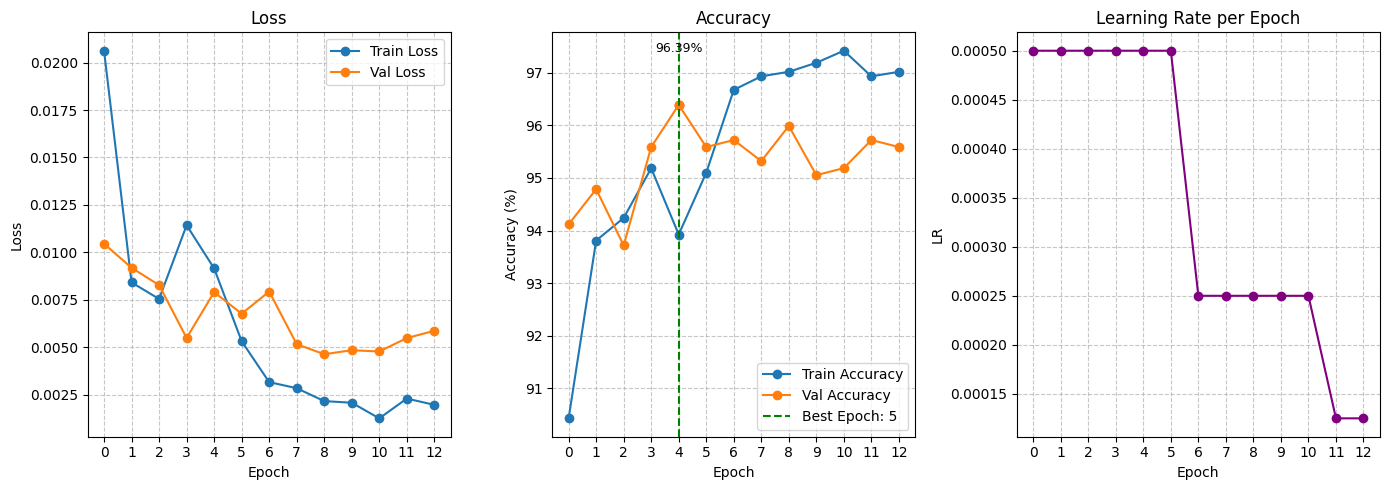

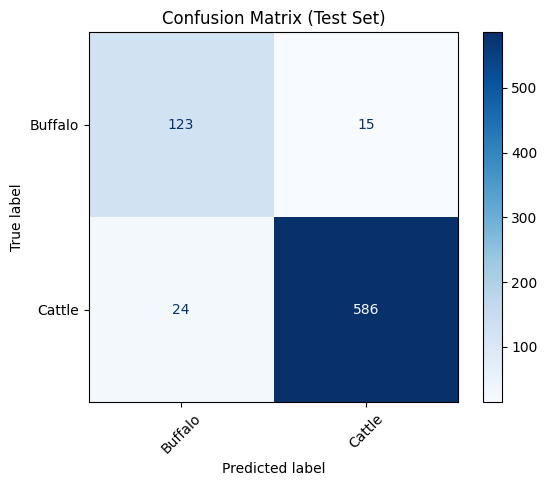

              precision    recall  f1-score   support

     Buffalo       0.84      0.89      0.86       138
      Cattle       0.98      0.96      0.97       610

    accuracy                           0.95       748
   macro avg       0.91      0.93      0.92       748
weighted avg       0.95      0.95      0.95       748



In [13]:
# 📊 Plot metrics after training
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, lrs)

# 🧪 Evaluate best model on test set
evaluate_on_test()

In [14]:
print(f"Found {len(misclassified_images)} misclassified images.")

# Display the first few misclassified images using the visualize_gradcam function
# You can change the number of images to display by changing the slice [ :5]
for path, pred, label in misclassified_images[:53]:
    print(f"Image: {path}, Predicted: {idx_to_class[pred]}, True: {idx_to_class[label]}")
    #visualize_gradcam(path, model, list(idx_to_class.values()), true_label=label)

Found 39 misclassified images.
Image: /kaggle/input/bovine-extended-data/bovine/Cattle/Brown_Swiss_203.jpg, Predicted: Buffalo, True: Cattle
Image: /kaggle/input/bovine-extended-data/bovine/Buffalo/Toda_50.jpg, Predicted: Cattle, True: Buffalo
Image: /kaggle/input/bovine-extended-data/bovine/Buffalo/Nagpuri_141.jpg, Predicted: Cattle, True: Buffalo
Image: /kaggle/input/bovine-extended-data/bovine/Cattle/Kankrej_47.png, Predicted: Buffalo, True: Cattle
Image: /kaggle/input/bovine-extended-data/bovine/Cattle/Alambadi_27.png, Predicted: Buffalo, True: Cattle
Image: /kaggle/input/bovine-extended-data/bovine/Cattle/Amritmahal_39.jpg, Predicted: Buffalo, True: Cattle
Image: /kaggle/input/bovine-extended-data/bovine/Cattle/Kankrej_155.jpg, Predicted: Buffalo, True: Cattle
Image: /kaggle/input/bovine-extended-data/bovine/Cattle/Holstein_Friesian_159.jpg, Predicted: Buffalo, True: Cattle
Image: /kaggle/input/bovine-extended-data/bovine/Buffalo/Jaffrabadi_95.jpg, Predicted: Cattle, True: Buffalo

In [15]:
for path, pred, label in misclassified_images[:5]:
    visualize_gradcam(path,model,'Buffalo', true_label=label)


NameError: name 'visualize_gradcam' is not defined